In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
import scipy as sp
from sklearn.linear_model import Lasso
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression


## Load data

In [3]:
dev_df = pd.read_csv("dataset/dev.tsv", sep ="\t")
eval_df =  pd.read_csv("dataset/eval.tsv", sep ="\t")

## DROP DUPLICATES


dev_df = dev_df.drop_duplicates(keep = False)
dataset = dev_df.copy()

### Some analysis

In [ ]:
dataset.info()

In [ ]:
dataset.describe()

In [ ]:
for col in dataset.columns:
    print(f"{col}: {dataset[col].unique().shape[0]}")

#### Missing values and case normalization

In [4]:
df = dataset.copy().fillna('')
df.description=df.description.str.lower()
df.country=df.country.str.lower()
df.designation=df.designation.str.lower()
df.province=df.province.str.lower()
df.region_1=df.region_1.str.lower()
df.region_2=df.region_2.str.lower()
df.variety=df.variety.str.lower()
df.winery=df.winery.str.lower()


##### Categorical encoding: One Hote Encoding


In [5]:
enc = OneHotEncoder(sparse = True, handle_unknown= 'ignore')

df_1 = enc.fit_transform(df.drop(columns=['description', 'quality']))#

#### Description handling - Vectorizer

In [6]:
from sklearn.feature_extraction.text import  TfidfVectorizer
from nltk.corpus import stopwords as sw

var_vectorizer = TfidfVectorizer(stop_words="english", binary=True, use_idf=False, norm=False)
# word presence matrix (i-th row, j-th col => 1 if j-th word is contained in i-th title)
wpm = var_vectorizer.fit_transform(dataset["description"])


In [7]:
#wpm_df = pd.DataFrame.sparse.from_spmatrix(wpm)
wpm.shape

(120744, 28903)

### Merge the encoded matricies

In [8]:
X_dev = sp.sparse.hstack((wpm, df_1))
X_dev.shape

(120744, 72964)

### TruncatedSVD

Variance explained by 1515 components: 0.90


Text(0, 0.5, 'Variance explained')

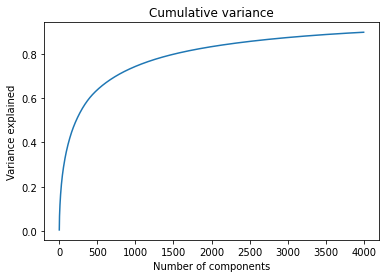

In [22]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD( n_components=4000,random_state=42)#
X_svd = svd.fit_transform(X_dev)

cum_variance = np.cumsum(svd.explained_variance_ratio_)
idx = np.argmax(cum_variance > .8)

print(f"Variance explained by {idx} components: {np.sum(svd.explained_variance_ratio_):.2f}")

from matplotlib import pyplot as plt
explained_pca = np.cumsum(svd.explained_variance_ratio_)
#Plotting cumulative variance
plt.plot(cum_variance)
plt.title('Cumulative variance')
plt.xlabel('Number of components')
plt.ylabel('Variance explained')

In [ ]:
num_comps = 1515

svd = TruncatedSVD(n_components= num_comps, random_state=42)#
X_svd = svd.fit_transform(X_dev)

print(f"Variance explained by {num_comps} components: {np.sum(svd.explained_variance_ratio_):.2f}")




Just for the plots.

In [26]:
results = {}
for n in [50,100,200,400,800, 1500]:
    X = X_dev.copy()
    svd = TruncatedSVD(n_components= n, random_state=42)#
    X_svd = svd.fit_transform(X)
    variance = np.sum(svd.explained_variance_ratio_)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_svd, y, shuffle=True, random_state=42)
    reg = RandomForestRegressor(100, random_state=42, n_jobs = 4)
    reg.fit(X_train , y_train)
    r2 = r2_score(y_valid, reg.predict(X_valid))
    
    results[n] = [variance, r2]
    print(f"r2_score for {n}: ",r2)

r2_score for 50:  0.38715697197348553
r2_score for 100:  0.40466334548940586
r2_score for 200:  0.4129447611497039
r2_score for 400:  0.41114419133582236
r2_score for 800:  0.409081852090726
r2_score for 1500:  0.40425056932030135


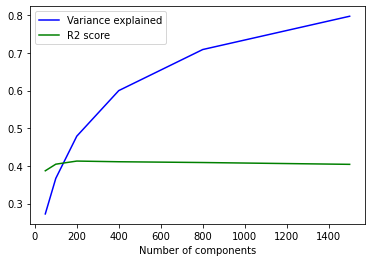

In [37]:
from matplotlib import pyplot as plt

x = []
var = []
r2_list = []
for k, v in results.items():
    x.append(k)
    var.append(v[0])
    r2_list.append(v[1])
x

fig = plt.figure()
ax=fig.add_subplot(111)
 
ax.plot(x,var,c='b',label='Variance explained')
ax.plot(x,r2_list,c='g',label='R2 score')

plt.xlabel("Number of components")
plt.legend(loc=2)
plt.show()

### RandomForestRegressor

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_svd, y, shuffle=True, random_state=42)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

reg = RandomForestRegressor(100, random_state=42, n_jobs = 4)
reg.fit(X_train , y_train)
r2 = r2_score(y_valid, reg.predict(X_valid))
print("r2_score: ",r2)

In [ ]:
sorted(zip(feature_names, reg.feature_importances_), key=lambda x: x[1], reverse=True)[:1000]

## Lasso and Ridge

In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#X_df = X_dev.copy()
#X_df = encoded_df.copy()

train_valid_mask = ~dataset["quality"].isna()
# extract the feature names (for later use)
#feature_names = X_df[train_valid_mask].columns

y = dataset["quality"].values


def evaluate_model(X, y, model, model_name):
    
   
    
    X_train_valid = X#[train_valid_mask]#train_valid_mask
    y_train_valid = y#[train_valid_mask]#train_valid_mask
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, shuffle=True, random_state=42)
    
    model.fit(X_train, y_train)
    y_hat = model.predict(X_valid)
    
    return mean_squared_error(y_valid, y_hat), r2_score(y_valid, y_hat)

In [10]:

models = [
        
        Ridge(random_state=42),
        Lasso(random_state= 42),
        #MLPRegressor(random_state=42,activation='logistic',alpha=0.01,verbose=True,hidden_layer_sizes=(100,100),learning_rate='adaptive',solver='sgd',learning_rate_init=0.01)
]


names = [
'ridge',
'lasso',
    #'mlp'
    
]

### Evaluate Lasso, Ridge and MLPRegressor

In [11]:
print(f"TEST on X_dev: {X_dev.shape} and y_dev: {y.shape}")
for model, name in zip(models, names):
    mse, r2 = evaluate_model(X_dev, y, model, name)
    print(f"[{name, mse, r2}]")

TEST on X_dev: (120744, 72964) and y_dev: (120744,)
[('ridge', 26.336291776861703, 0.815426750044667)]
[('lasso', 142.68922990517825, -1.2269015071453282e-05)]


## Grid Search on Lasso

In [12]:

from sklearn.model_selection import GridSearchCV
param_grid = {
        'alpha':[1],#,0.1,0.01,0.001,0.0001,0.005, 0.05],
        "fit_intercept":[True],# False],
        "random_state": [42], # always use the samet random seed
    }

gs = GridSearchCV(Ridge(), param_grid, scoring="r2", n_jobs=4, cv=5)

In [13]:
gs.fit(X_dev, y)
print(gs.best_score_)

0.8226237474012855


In [14]:
print(gs.best_params_)
#print(gs.best_estimator_.feature_importances_)
print(gs.best_estimator_)

{'alpha': 1, 'fit_intercept': True, 'random_state': 42}
Ridge(alpha=1, random_state=42)


## Ridge Pipeline

In [26]:
# Regression model that we want to configure:
reg = make_pipeline(PolynomialFeatures(degree = 3), Ridge())

param_grid = {'polynomialfeatures__degree':[3], 
              'ridge__alpha':[1]}
gs = GridSearchCV(reg, param_grid, scoring='r2', cv=5)

In [ ]:
reg.fit(X_dev, y)
print(gs.best_score_)

In [ ]:
print(gs.best_params_)
#print(gs.best_estimator_.feature_importances_)
print(gs.best_estimator_)

## Predict

In [15]:
df = eval_df.copy().fillna('')

df.description=df.description.str.lower()
df.country=df.country.str.lower()
df.designation=df.designation.str.lower()
df.province=df.province.str.lower()
df.region_1=df.region_1.str.lower()
df.region_2=df.region_2.str.lower()
df.variety=df.variety.str.lower()
df.winery=df.winery.str.lower()
X_test = df.copy()
X_test.columns


Index(['country', 'description', 'designation', 'province', 'region_1',
       'region_2', 'variety', 'winery'],
      dtype='object')

In [16]:
## encoded eval description
encoded_eval = enc.transform(X_test.drop(columns= ['description'], axis =1))

X_test_bin = encoded_eval.copy()
print(f"Training shape: {df_1.shape},  Testing: {X_test_bin.shape}")

Training shape: (120744, 44061),  Testing: (30186, 44061)


In [17]:
## description handle
wpm_test = var_vectorizer.transform(eval_df['description'])
#X_test_svd = svd.transform(X_test_tfidf)
X_test_svd = pd.DataFrame.sparse.from_spmatrix(wpm_test)
print(f"Training shape: {wpm.shape},  Testing: {wpm_test.shape}")

Training shape: (120744, 28903),  Testing: (30186, 28903)


In [18]:
## MERGE

X_test = sp.sparse.hstack((wpm_test, X_test_bin))
#X_test = X_test_bin
print(f"Training shape: {X_dev.shape},  Testing: {X_test.shape}")

Training shape: (120744, 72964),  Testing: (30186, 72964)


In [19]:
y_pred = gs.predict(X_test)
pd.DataFrame(y_pred, index=eval_df.index).to_csv("final_dip.csv", index_label="Id", header=["Predicted"])